# Description

After all the simulation has been completed, the idea is to do model selection by first sorting on the correlation between two columns (lower correlation is better), and then sorting based on returns (high returns are better). This is to promote feature/routine/random seed diversity, while also not sacrificing returns.

It is benchmarked against the ComboSearch method.

In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

from ram.analysis.run_manager import RunManagerGCP
from ram.analysis.combo_search import CombinationSearch
from ram.analysis.statistics import get_stats, rollup_returns

In [4]:
RunManagerGCP.get_run_names('StatArbStrategy2')

,Run,RunDate,Completed,Description,Starred
0,run_0001,2018-02-15,True,"Smart factor, sector 20",
1,run_0002,2018-02-15,True,"Smart factor, all sectors",
2,run_0003,2018-02-22,True,"New run with smart factor, sector 20",
3,run_0004,2018-02-20,False,"New run with smart factor, sector 25",
4,run_0005,2018-02-20,False,"New run with smart factor, sector 45",
5,run_0007,2018-02-23,True,"Sector 20, new params, more features for sort",
6,run_0009,2018-02-24,True,"Bayes, Sector 20",
7,run_0012,2018-02-28,True,"Sector20, mult",


In [5]:
run1 = RunManagerGCP('StatArbStrategy2', 'run_0007')

comb1 = CombinationSearch()
comb1.add_run(run1)
comb1.start(10, 'mean')

  0%|          | 0/1 [00:00<?, ?it/s]

Reading and aggregating runs...


  0%|          | 0/10 [00:00<?, ?it/s]

Finished aggregating runs...


100%|██████████| 10/10 [01:23<00:00,  8.38s/it]


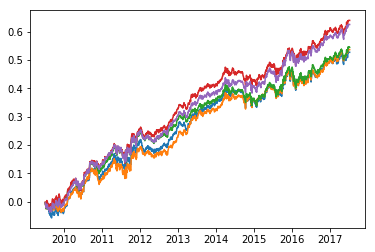

In [6]:
plt.figure()
plt.plot(comb1.best_results_rets.dropna().cumsum())
plt.show()

#### Correlation Implementation

In [9]:
def create_uncorrelated_portfolio_returns(train_dates, test_dates, returns, corr_filter_val=0.05):
    """
    Parameters
    ----------
    train_dates/test_dates : list/array
        Dates for specific period. Dates should not overlap
    returns : pd.DataFrame
        This has dates in the index, and models in the columns. Data should be returns
    corr_filter_val : float
        Percentage of the combinations of columns should be kept

    Returns
    -------
    test_returns : pd.Series
    """
    train = returns.loc[train_dates]
    test = returns.loc[test_dates]

    # Get ABS correlations and filter redundant information
    correlations = train.corr().abs().unstack().reset_index()
    correlations.columns = ['ColA', 'ColB', 'Correlation']
    correlations.ColA = correlations.ColA.astype(int)
    correlations.ColB = correlations.ColB.astype(int)
    correlations = correlations[correlations.ColA < correlations.ColB]

    # Filter by correlation rank (from hyperparameter)
    correlations['CorrRank'] = correlations.Correlation.rank(pct=True)
    correlations = correlations.sort_values('CorrRank')
    correlations = correlations[correlations.CorrRank < corr_filter_val]

    # Create combined returns by taking simple average for every day
    R1 = train.iloc[:, correlations.ColA].values
    R2 = train.iloc[:, correlations.ColB].values
    correlations.loc[:, 'Rets'] = ((R1 + R2) / 2.).sum(axis=0)

    # Rank and sort by return
    correlations['RetsRank'] = correlations.Rets.rank(pct=True)
    correlations = correlations.sort_values('RetsRank', ascending=False)

    # Get a set of the top 5 (avoids doubling up on a single strategy)
    n_cols = 5
    top_columns = set(correlations.ColA.iloc[:n_cols]).union(correlations.ColB.iloc[:n_cols])

    # Combines all the selected columns into pd.Series
    return test.iloc[:, list(top_columns)].mean(axis=1)

In [10]:
def iterate_portfolio_selection(returns, start_index=300, test_period_len=10, growing_training_set=True,
                                corr_filter_val=0.05):
    """
    Parameters
    ----------
    returns : pd.DataFrame
        This has dates in the index, and models in the columns. Data should be returns
    start_index : int
        Number of trading days in initial optimization
    test_period_len : int
        Number of trading days until re-optimization
    growing_training_set : bool
        If false, the training set will be of length `start_index`
    corr_filter_val : float
        Percentage of the combinations of columns should be kept
    """
    all_dates = returns.index

    output = pd.Series()

    # Indexes for getting dates
    i1 = start_index
    i2 = i1 + test_period_len

    while True:
        # Get dates for function
        train_dates = all_dates[:i1]
        test_dates = all_dates[i1:i2]

        # Trim training date length if specified
        if not growing_training_set:
            train_dates = train_dates[-start_index:]

        period_rets = create_uncorrelated_portfolio_returns(train_dates, 
                                                            test_dates, 
                                                            returns, 
                                                            corr_filter_val=corr_filter_val)

        output = output.append(period_rets)

        i1 = int(i2)
        i2 = i2 + test_period_len

        if x1 >= len(all_dates):
            break

    return output

In [11]:
returns = run1.returns.copy()

rets1 = iterate_portfolio_selection(returns, start_index=300, test_period_len=10, 
                                    growing_training_set=True, corr_filter_val=0.05)

NameError: global name 'x1' is not defined

# Conclusion